In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.linalg import expm, fractional_matrix_power

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

from scipy.stats import zscore

from tqdm.auto import tqdm

import networkx as nx
import igraph as ig

from utils.Multiscale.load_data import load_dict
from utils.Multiscale.multiscale_functions import laplacian_matrix
from netneurotools import plotting, cluster
from netneurotools.metrics import communicability_bin, communicability_wei

import utils.CommonFunctions as cf
import utils.plotter as plotter

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/home/barzon/.local/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


# Data visualization

In [2]:
data = load_dict('data/LAU1000')

In [3]:
data['sc'].shape

(1000, 1000)

In [4]:
data.keys()

dict_keys(['sc', 'fc', 'coords', 'lhannot', 'rhannot', 'noplot', 'order', 'rsn', 'rsn_names', 've', 've_names', 'ci'])

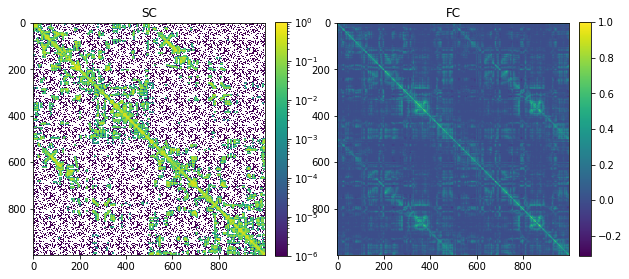

In [5]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(data['sc'], norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,2,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.show()

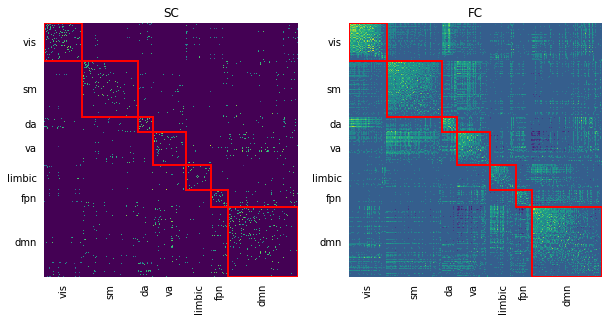

In [6]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(1,2,1)
plotting.plot_mod_heatmap(data['sc'], data['rsn'], ax=ax1, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('SC')

ax2 = plt.subplot(1,2,2)
plotting.plot_mod_heatmap(data['fc'], data['rsn'], ax=ax2, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('FC')

plt.show()

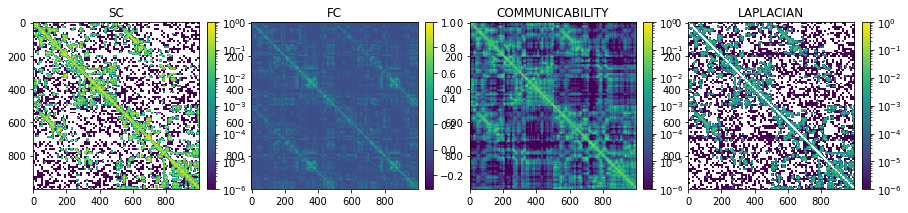

In [9]:
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(data['sc'], norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,4,2)
plt.imshow(data['fc'])
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.subplot(1,4,3)
plt.imshow(communicability_wei(data['sc']), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('COMMUNICABILITY')

plt.subplot(1,4,4)
plt.imshow(-laplacian_matrix(data['sc']), norm=LogNorm(vmin=1e-6, vmax=1))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('LAPLACIAN')

plt.show()

In [198]:
ts = [[0.001, 0.01, 0.1, 1], [2, 5, 10, 20]]
ts = np.array(ts)

mat_dd = []

for i,t in enumerate(ts.flatten()):
    print('* {}/{} - t={}'.format(i+1,len(ts.flatten()),t))
    tmp = diffusion_distance(sc_left, t=t)
    mat_dd.append(tmp)

* 1/8 - t=0.001
* 2/8 - t=0.01
* 3/8 - t=0.1
* 4/8 - t=1.0
* 5/8 - t=2.0
* 6/8 - t=5.0
* 7/8 - t=10.0
* 8/8 - t=20.0


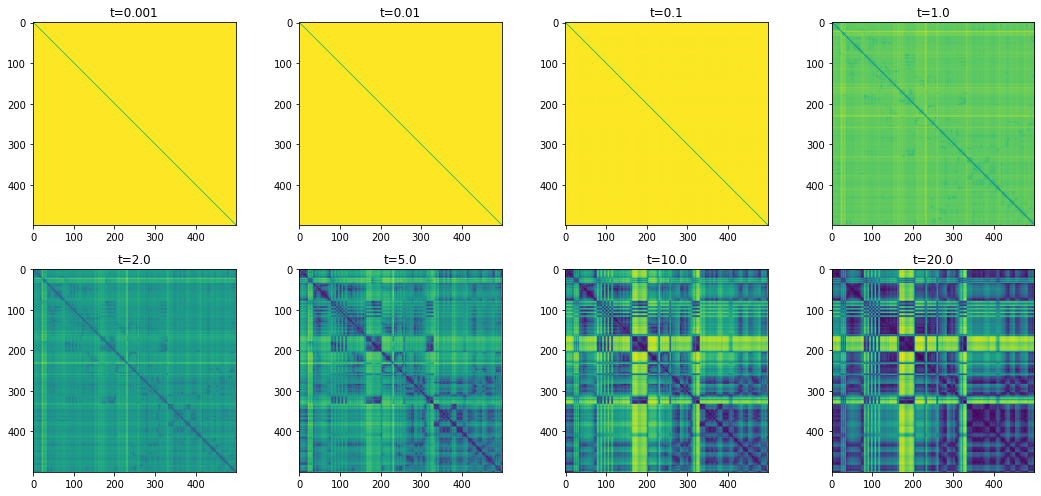

In [199]:
ts = [[0.001, 0.01, 0.1, 1], [2, 5, 10, 20]]
ts = np.array(ts)

plt.figure(figsize=(15,7))

for (x,y), t in np.ndenumerate(ts):
    ax = plt.subplot(ts.shape[0],ts.shape[1],x*ts.shape[1]+y+1)
    plt.imshow(mat_dd[x*ts.shape[1]+y])
    plt.title('t='+str(t))
    
plt.tight_layout()
plt.show()

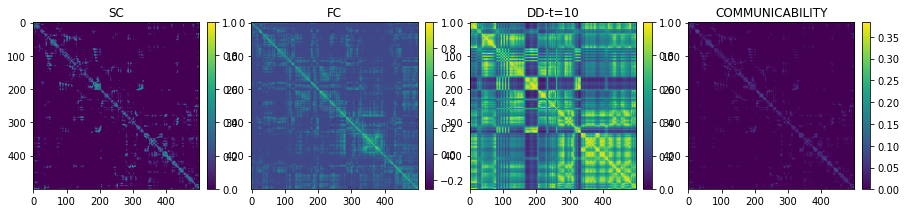

In [53]:
tt = 3

plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(sc_left)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('SC')

plt.subplot(1,4,2)
plt.imshow(fc_left)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('FC')

plt.subplot(1,4,3)
plt.imshow(1-mat_dd[tt]/np.max(mat_dd[tt]))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('DD-t='+str(ts.flatten()[tt]))

plt.subplot(1,4,4)
plt.imshow(communicability_wei(sc_left))
plt.colorbar(fraction=0.046, pad=0.04)
#plt.axis('off')
plt.title('COMMUNICABILITY')

plt.show()

/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


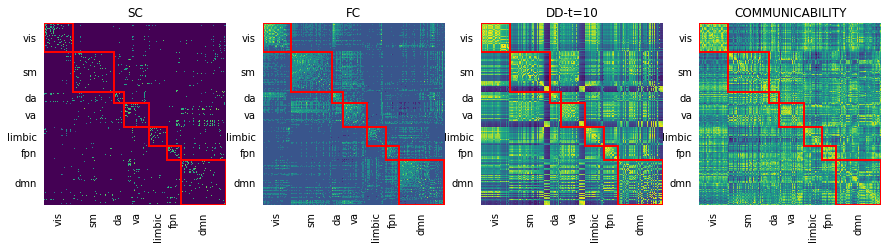

In [54]:
tt = 3

plt.figure(figsize=(15,15))

ax = plt.subplot(1,4,1)
plotting.plot_mod_heatmap(sc_left, rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('SC')

ax = plt.subplot(1,4,2)
plotting.plot_mod_heatmap(fc_left, rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('FC')

ax = plt.subplot(1,4,3)
plotting.plot_mod_heatmap(1-mat_dd[tt]/np.max(mat_dd[tt]), rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('DD-t='+str(ts.flatten()[tt]))

ax = plt.subplot(1,4,4)
plotting.plot_mod_heatmap(np.log10(communicability_wei(sc_left)), rsn_left, ax=ax, cbar=False, xlabels=data['rsn_names'], ylabels=data['rsn_names'], edgecolor='red')
plt.title('COMMUNICABILITY')

plt.show()

# Community detection
see https://igraph.org/python/api/develop/igraph.community.html for clustering methods <br>
see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for evaluation metrics

In [7]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score

In [8]:
def community_detection(mat, method, *args):
    graph = ig.Graph.Weighted_Adjacency(mat.tolist(), mode=ig.ADJ_UNDIRECTED, attr="weight", loops=False)
    
    if method == 'louvain':
        comms = graph.community_multilevel(weights=graph.es['weight'], return_levels=False)
    elif method == 'leiden':
        if len(args)>0:
            resolution_parameter = args[0]
        comms = graph.community_leiden(weights=graph.es['weight'], resolution_parameter=resolution_parameter, n_iterations=-1, objective_function='modularity') #objective_function: Constant Potts Model (CPM) or modularity
    elif method == 'spin_glass':
        comms = graph.community_spinglass(weights=graph.es['weight'], spins=int(1e3))
    elif method == 'infomap':
        comms = graph.community_infomap(edge_weights=graph.es['weight'], trials=10)
    else:
        raise( Exception('Community detection method not defined.\n'))
    
    return comms.membership

def metrics(comms_true, comms_emp, method):
    if method == 'nmi':
        score = normalized_mutual_info_score(comms_true, comms_emp)
    elif method == 'ami':
        score = adjusted_mutual_info_score(comms_true, comms_emp)
    elif method == 'ari':
        score = adjusted_rand_score(comms_true, comms_emp)
    else:
        raise(Exception('Evaluation method not defined.\n'))
    
    return score

## - Louvain

In [9]:
comms = []
mats = [data['sc'], communicability_wei(data['sc'])]
mat_names = ['SC', 'CC']
method = 'louvain'
scores = ['ami', 'ari']
    
for i, mat in enumerate(mats):
    print('[*] Matrix: '+str(mat_names[i]))
    
    Q = [community_detection(mat, method) for _ in range(100)]
    Q = cluster.find_consensus(np.column_stack(Q))
    print('N cluster: ', len(np.unique(Q)))
    
    comms.append(Q)

[*] Matrix: SC
N cluster:  6
[*] Matrix: CC


KeyboardInterrupt: 

In [ ]:
results = [[metrics(data['rsn'], comm, score) for comm in comms] for score in scores]

for i, res in enumerate(results):
    plt.plot(mat_names, res, '*', label=scores[i])
    
plt.ylabel('score')
plt.title(method)
plt.legend()
plt.show()

In [17]:
comms = []
mats = [data['sc'], communicability_wei(data['sc']), -laplacian_matrix(data['sc']), data['fc']]
mat_names = ['SC', 'CC', 'LP', 'FC']
method = 'louvain'
scores = ['ami', 'ari']
    
for i, mat in enumerate(mats):
    print('[*] Matrix: '+str(mat_names[i]))
    
    mat = zscore(mat)
    mat -= mat.min()
        
    Q = [community_detection(mat, method) for _ in range(100)]
    Q = cluster.find_consensus(np.column_stack(Q))
    print('N cluster: ', len(np.unique(Q)))
    
    comms.append(Q)

[*] Matrix: SC
N cluster:  6
[*] Matrix: CC
N cluster:  6
[*] Matrix: LP
N cluster:  2
[*] Matrix: FC
N cluster:  4


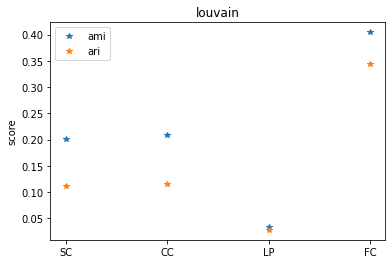

In [19]:
results = [[metrics(data['rsn'], comm, score) for comm in comms] for score in scores]

for i, res in enumerate(results):
    plt.plot(mat_names, res, '*', label=scores[i])
    
plt.ylabel('score')
plt.title(method)
plt.legend()
plt.show()

## -Diffusion distance

In [11]:
def laplacian(mat):
    return np.eye(len(mat)) - mat / np.sum(mat, axis=1)[:,None]

def diffusion_distance(mat, t, method='rwL'):
    num_nodes = len(mat)
    
    #lapl = laplacian_matrix(mat, method)
    lapl = laplacian(mat)
    expL = expm(-lapl*t)

    d_ij = np.zeros((num_nodes,num_nodes))
    
    for i in range(0, num_nodes-1):
        for j in range(i+1, num_nodes):
            d_ij_tmp = expL[i] - expL[j]
            d_ij[i,j] = np.sqrt(d_ij_tmp.dot(d_ij_tmp))
            
    return d_ij + d_ij.T

def average_diffusion_distance(mat, tmax=None, display=True, return_snapshot=False, method='rwL'):
    N = mat.shape[0]
    if tmax is None:
        tmax = N
    #ts = np.arange(1, tmax+1)

    d_t_ij = np.zeros((tmax,N,N))
    
    if display:
        for t in tqdm(range(1, tmax+1)):
            d_t_ij[t-1] = diffusion_distance(mat, t, method)
    else:
        for t in range(1, tmax+1):
            d_t_ij[t-1] = diffusion_distance(mat, t, method)
    
    average = np.mean(d_t_ij, axis=0)
    
    if return_snapshot:
        return average, d_t_ij
    else:
        return average

def induced_graph(mat, Z, n_clust):
    # Initialize arrays
    comms_name = np.arange(n_clust)
    new_adj = np.zeros((n_clust, n_clust))
    
    # Get communities
    comms = fcluster(Z, t=n_clust, criterion='maxclust') -1
    N = len(comms)
    
    for node1 in np.arange(N):
        for node2 in np.arange(node1,N):
            new_adj[comms[node1], comms[node2]] += mat[node1,node2]
            
    # Symmetrize and return
    return new_adj + new_adj.T

def plot_communities(mat, comms):
    n_comms = len(np.unique(comms))
    cmap = plt.cm.get_cmap('plasma', n_comms)
    node_color = [cmap(i) for i in comms]
    nx.draw(nx.from_numpy_array(mat), node_color=node_color, with_labels=False)
    plt.show()

def clustering_diffusion_distance(mat, precomputed=None, clust_max=20, show=True, method='complete'):
    '''
    method = single, complete, average, weighted, centroid, median, ward
    '''
    
    print('COMMUNITY DETECTION - DIFFUSION DISTANCE')
    N = mat.shape[0]
    
    # Define total number of clusters to check
    n_clusters = np.arange(2,clust_max)
    n_clusters = np.append(n_clusters, [50, 100])
    mean_dd = np.zeros(len(n_clusters))
    
    # Compute average diffusion distance
    if precomputed is None:
        print('- Compute average diffusion distance...')
        avg_dd = average_diffusion_distance(mat)
    else:
        print('- Diffusion distance already computed...')
        avg_dd = precomputed
    
    # Compute hierarchical clustering
    print('- Compute hierarchical clustering with method {}...'.format(method))
    Z = linkage(squareform(avg_dd), method=method)
    
    print('- Loop over induced graphs - max clust = {}...'.format(clust_max))
    for i, n_clust in enumerate(n_clusters):
        # Compute induced graph
        mat_induced = induced_graph(mat, Z, n_clust)
        
        # Compute diff distance on induced graph
        avg_dd_induced = average_diffusion_distance(mat_induced, display=False)
        
        mean_dd[i] = np.mean(avg_dd_induced[np.triu_indices(n_clust,0)])
        #mean_dd[i] = np.mean(avg_dd_induced)
        
        #print('[*] n clust = {} - avg diff dist = {}'.format(n_clust, np.round(mean_dd[i],3)))
    
    # Get best partition
    best_clust = n_clusters[np.argmax(mean_dd)]
    best_part = fcluster(Z, t=best_clust, criterion='maxclust') -1
    
    if show:
        plt.figure()
        plt.plot(n_clusters, mean_dd, 'o-')
        plt.xlabel('n clust')
        plt.ylabel('mean diff dist')
        plt.plot(n_clusters[np.argmax(mean_dd)], mean_dd[np.argmax(mean_dd)], 'o', c='red', label=f'best={best_clust}')
        plt.legend()
        plt.show()
        
        plot_communities(mat, best_part)
    
    return n_clusters, mean_dd, best_clust, best_part

In [22]:
ts = [[0.001, 0.01, 0.1, 1], [2, 5, 10, 20]]
ts = np.array(ts)

mat_dd = []

for i,t in enumerate(ts.flatten()):
    print('* {}/{} - t={}'.format(i+1,len(ts.flatten()),t))
    tmp = diffusion_distance(data['sc'], t=t)
    mat_dd.append(tmp)

* 1/8 - t=0.001
* 2/8 - t=0.01
* 3/8 - t=0.1
* 4/8 - t=1.0
* 5/8 - t=2.0
* 6/8 - t=5.0
* 7/8 - t=10.0
* 8/8 - t=20.0


In [18]:
avg_ts = []

ts = [1, 10, 20, 50, 100]

for t in ts:
    avg_dd = average_diffusion_distance(data['sc'], tmax=t)
    avg_ts.append(avg_dd)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

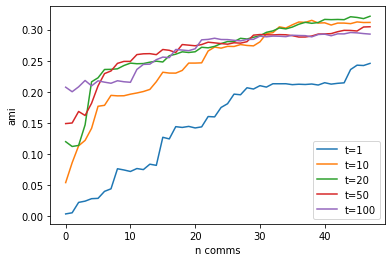

In [32]:
n_states = np.arange(2,50)

for i, avg_dd in enumerate(avg_ts):
    Z = linkage(squareform(avg_dd), method='complete')
    res = []
    for n_stat in n_states:
        comms_emp = fcluster(Z, t=n_stat, criterion='maxclust') -1
        
        score = adjusted_mutual_info_score(data['rsn'], comms_emp)
        res.append(score)
    plt.plot(res, label=f't={ts[i]}')
    
plt.xlabel('n comms')
plt.ylabel('ami')
plt.legend()
plt.show()

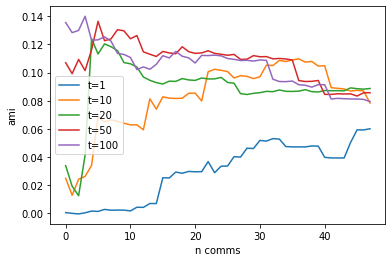

In [27]:
n_states = np.arange(2,50)

for i, avg_dd in enumerate(avg_ts):
    Z = linkage(squareform(avg_dd), method='complete')
    res = []
    for n_stat in n_states:
        comms_emp = fcluster(Z, t=n_stat, criterion='maxclust') -1
        
        score = adjusted_rand_score(data['rsn'], comms_emp)
        res.append(score)
    plt.plot(res, label=f't={ts[i]}')
    
plt.xlabel('n comms')
plt.ylabel('ami')
plt.legend()
plt.show()

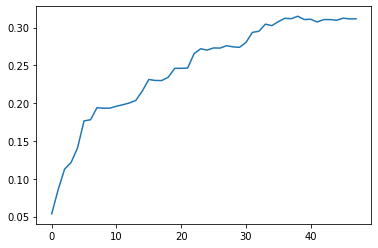

In [17]:
plt.plot(res)
plt.show()

In [ ]:
methods_clust = ['single', 'complete', 'average', 'weighted', 'ward']

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method single...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.05


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


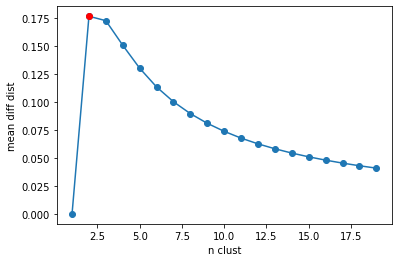

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.12


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


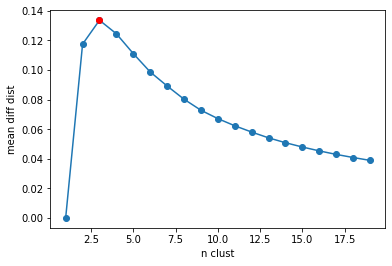

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method average...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.11


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


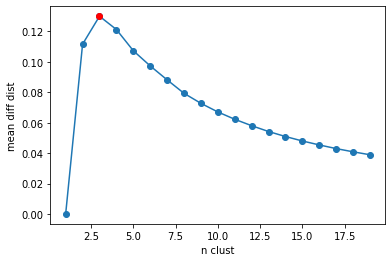

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.11


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


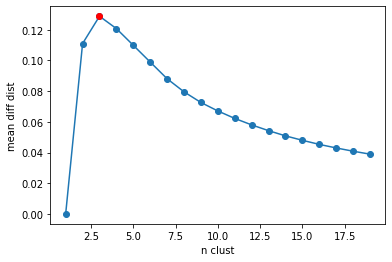

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method ward...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.11


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


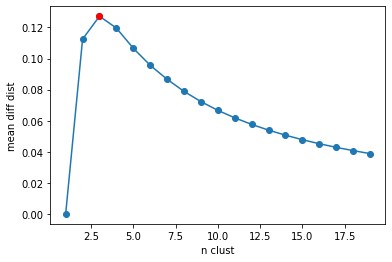

In [33]:
clust_dd = []

for method in methods_clust:
    tmp = clustering_diffusion_distance(avg_dd, precomputed=True, clust_max=20, show=True, method=method)
    clust_dd.append(tmp)

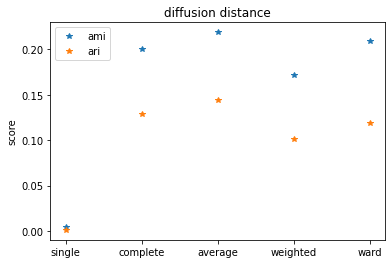

In [35]:
results = [[metrics(data['rsn'], tmp[-1], score) for tmp in clust_dd] for score in scores]

for i, res in enumerate(results):
    plt.plot(methods_clust, res, '*', label=scores[i])
    
plt.ylabel('score')

plt.title('diffusion distance')
plt.legend()
plt.show()

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.12


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.14


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


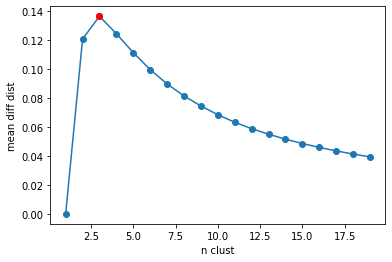

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.12


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


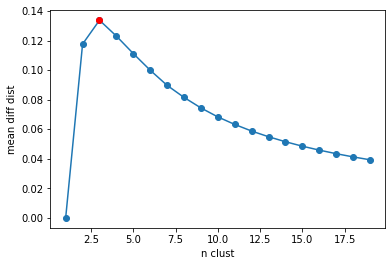

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.12


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


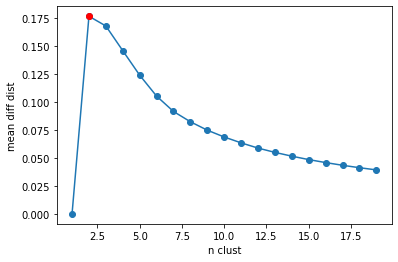

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


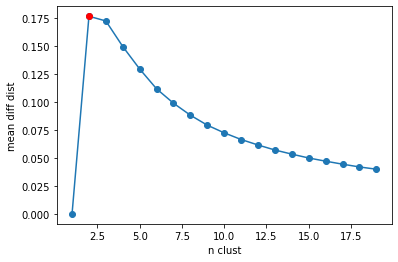

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


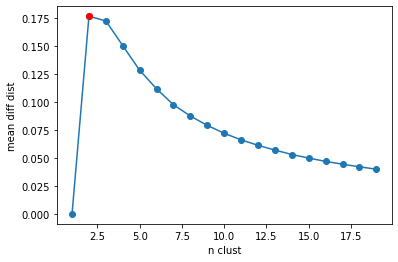

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.16


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.15


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.13


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.12


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


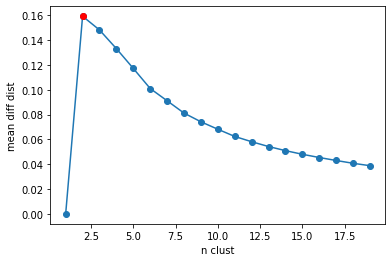

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.14


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


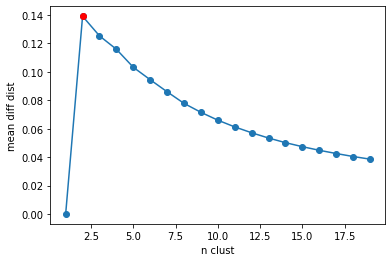

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.11


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.12


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.08


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


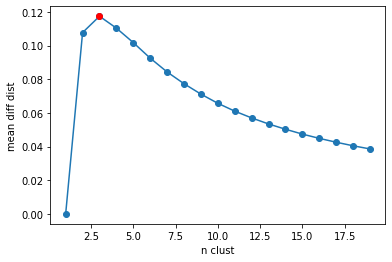

In [23]:
res_dd = []

for mat in mat_dd:
    tmp = clustering_diffusion_distance(mat, precomputed=True, clust_max=20, show=True, method='weighted')
    res_dd.append(tmp)

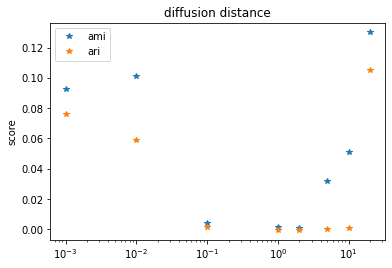

In [24]:
results = [[metrics(data['rsn'], tmp[-1], score) for tmp in res_dd] for score in scores]

for i, res in enumerate(results):
    plt.plot(ts.flatten(), res, '*', label=scores[i])
    
plt.ylabel('score')
plt.xscale('log')

plt.title('diffusion distance')
plt.legend()
plt.show()

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.05


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


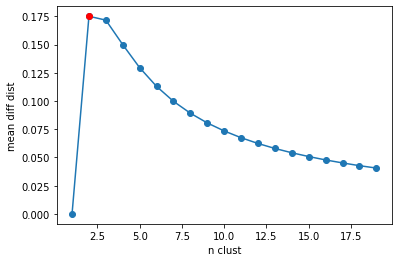

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.05


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


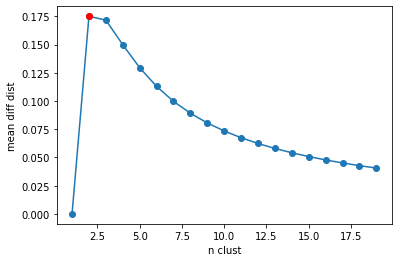

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.05


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


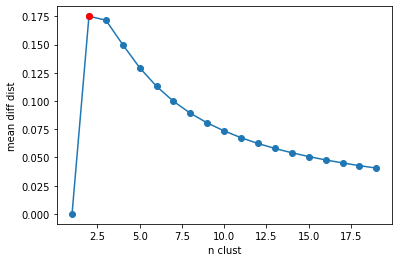

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


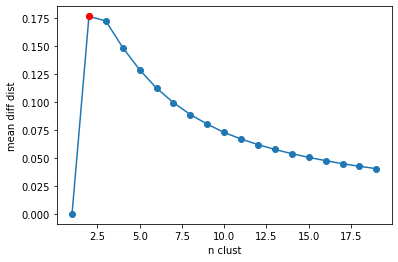

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


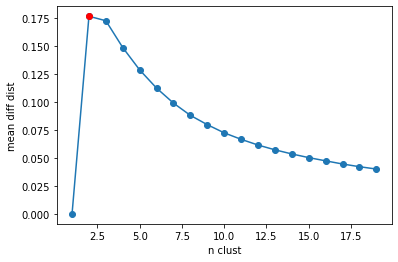

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.14


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.14


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


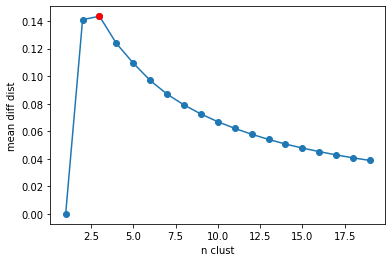

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.14


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.13


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


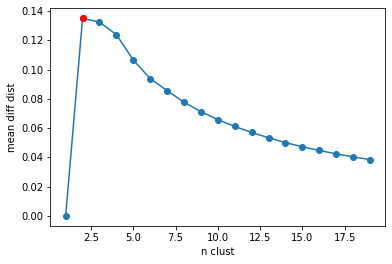

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.1


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.12


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.08


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.04


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


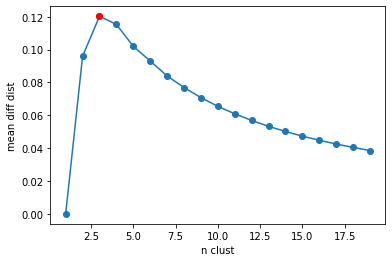

In [25]:
res_dd = []

for mat in mat_dd:
    tmp = clustering_diffusion_distance(mat, precomputed=True, clust_max=20, show=True, method='complete')
    res_dd.append(tmp)

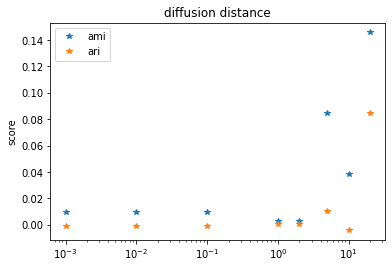

In [26]:
results = [[metrics(data['rsn'], tmp[-1], score) for tmp in res_dd] for score in scores]

for i, res in enumerate(results):
    plt.plot(ts.flatten(), res, '*', label=scores[i])
    
plt.ylabel('score')
plt.xscale('log')

plt.title('diffusion distance')
plt.legend()
plt.show()

### * Using normalized laplacian instead of random walk

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method single...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.17


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.17


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.15


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.13


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.11


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.1


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.09


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.08


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.07


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.06


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


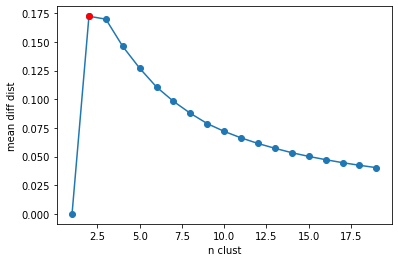

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method complete...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.09


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.11


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


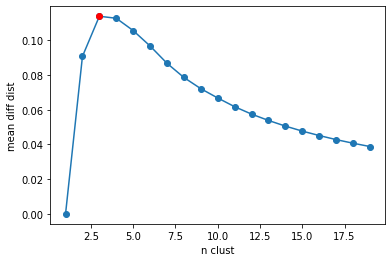

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method average...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.12


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.12


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


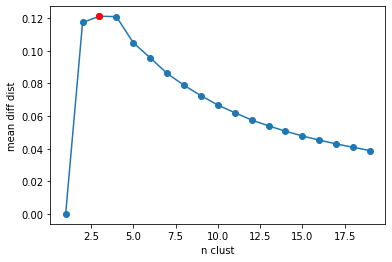

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method weighted...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.1


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.12


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.11


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.1


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


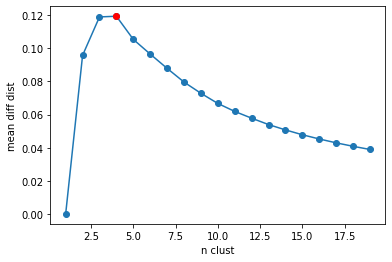

COMMUNITY DETECTION - DIFFUSION DISTANCE
- Diffusion distance already computed...
- Compute hierarchical clustering with method ward...
- Loop over induced graphs - max clust = 20...


  0%|          | 0/1 [00:00<?, ?it/s]

[*] n clust = 1 - avg diff dist = 0.0


  0%|          | 0/2 [00:00<?, ?it/s]

[*] n clust = 2 - avg diff dist = 0.09


  0%|          | 0/3 [00:00<?, ?it/s]

[*] n clust = 3 - avg diff dist = 0.11


  0%|          | 0/4 [00:00<?, ?it/s]

[*] n clust = 4 - avg diff dist = 0.11


  0%|          | 0/5 [00:00<?, ?it/s]

[*] n clust = 5 - avg diff dist = 0.1


  0%|          | 0/6 [00:00<?, ?it/s]

[*] n clust = 6 - avg diff dist = 0.09


  0%|          | 0/7 [00:00<?, ?it/s]

[*] n clust = 7 - avg diff dist = 0.09


  0%|          | 0/8 [00:00<?, ?it/s]

[*] n clust = 8 - avg diff dist = 0.08


  0%|          | 0/9 [00:00<?, ?it/s]

[*] n clust = 9 - avg diff dist = 0.07


  0%|          | 0/10 [00:00<?, ?it/s]

[*] n clust = 10 - avg diff dist = 0.07


  0%|          | 0/11 [00:00<?, ?it/s]

[*] n clust = 11 - avg diff dist = 0.06


  0%|          | 0/12 [00:00<?, ?it/s]

[*] n clust = 12 - avg diff dist = 0.06


  0%|          | 0/13 [00:00<?, ?it/s]

[*] n clust = 13 - avg diff dist = 0.05


  0%|          | 0/14 [00:00<?, ?it/s]

[*] n clust = 14 - avg diff dist = 0.05


  0%|          | 0/15 [00:00<?, ?it/s]

[*] n clust = 15 - avg diff dist = 0.05


  0%|          | 0/16 [00:00<?, ?it/s]

[*] n clust = 16 - avg diff dist = 0.05


  0%|          | 0/17 [00:00<?, ?it/s]

[*] n clust = 17 - avg diff dist = 0.04


  0%|          | 0/18 [00:00<?, ?it/s]

[*] n clust = 18 - avg diff dist = 0.04


  0%|          | 0/19 [00:00<?, ?it/s]

[*] n clust = 19 - avg diff dist = 0.04


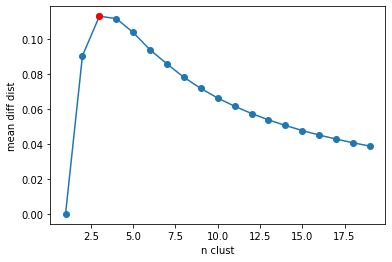

In [191]:
clust_dd = []

for method in methods_clust:
    tmp = clustering_diffusion_distance(avg_dd_2, precomputed=True, clust_max=20, show=True, method=method)
    clust_dd.append(tmp)

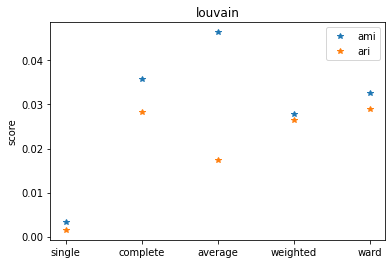

In [194]:
results = [[metrics(rsn_left, tmp[-1], score) for tmp in clust_dd] for score in scores]

for i, res in enumerate(results):
    plt.plot(methods_clust, res, '*', label=scores[i])
    
plt.ylabel('score')

plt.title(method)
plt.legend()
plt.show()

In [28]:
avg_dd

NameError: name 'avg_dd' is not defined